### Lets implement the sub question 5


In [1]:
import pandas as pd
import re
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap


In [2]:
channels_df = pd.read_csv(
    "../data/df_channels_en.tsv.gz", compression="infer", sep="\t"
)


In [3]:
metadatas_df = pd.read_feather(
    "../data/yt_metadata_helper.feather",
    columns=[
        "categories",
        "upload_date",
        "duration",
        "like_count",
        "dislike_count",
        "view_count",
        "channel_id",
    ],
)


In [4]:
channels_df.head()


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [5]:
metadatas_df.head()


,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id
0,Film & Animation,2016-09-28,1159,8.0,1.0,1057.0,UCzWrhkg9eK5I8Bm3HfV-unA
1,Film & Animation,2016-09-28,2681,23.0,1.0,12894.0,UCzWrhkg9eK5I8Bm3HfV-unA
2,Film & Animation,2016-09-28,1394,1607.0,779.0,1800602.0,UCzWrhkg9eK5I8Bm3HfV-unA
3,Film & Animation,2016-09-28,5064,227.0,24.0,57640.0,UCzWrhkg9eK5I8Bm3HfV-unA
4,Film & Animation,2016-09-28,3554,105.0,13.0,86368.0,UCzWrhkg9eK5I8Bm3HfV-unA


In [6]:
metadatas_df.shape


(72924794, 7)

Use the metadatas to notice if channels changed their content (category) sometimes.


In [7]:
INTERESTING_CAT = ["Gaming", "People & Blogs", "Comedy"]
INTERESTING_CAT_IDS = channels_df[channels_df.category_cc.isin(INTERESTING_CAT)].channel


Text(0, 0.5, 'Number of videos')

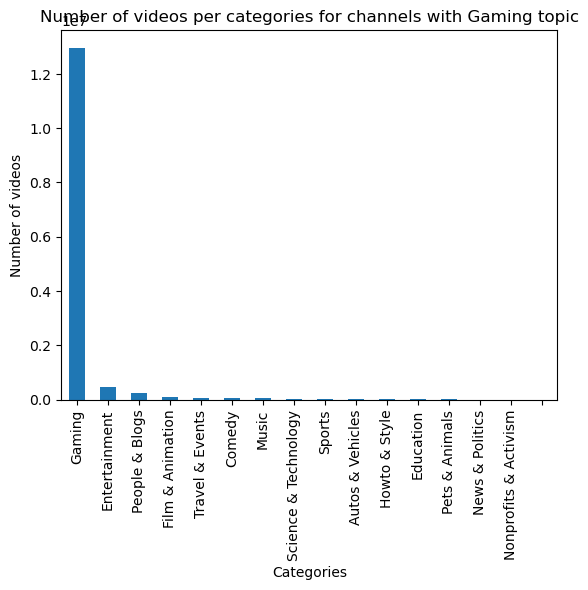

In [8]:
# select the channels as main topic "Gaming" and which are present in the channels df
comedy_ids = channels_df[channels_df.category_cc == "Gaming"].channel
# select these channels in the metadatas
metadatas_gaming = metadatas_df[metadatas_df.channel_id.isin(comedy_ids)]
metadatas_gaming.categories.value_counts().plot(kind="bar")
plt.title("Number of videos per categories for channels with Gaming topic")
plt.xlabel("Categories")
plt.ylabel("Number of videos")


Text(0, 0.5, 'Number of videos')

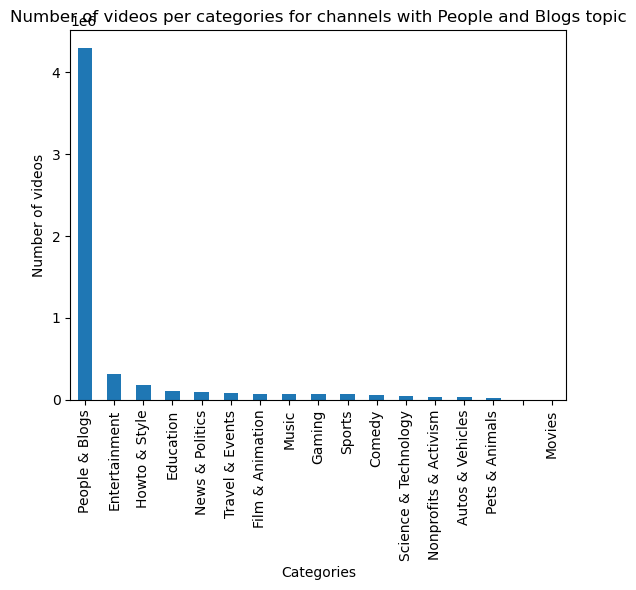

In [9]:
# select the channels as main topic "People & Blogs" and which are present in the channels df
comedy_ids = channels_df[channels_df.category_cc == "People & Blogs"].channel
# select these channels in the metadatas
metadatas_people_blogs = metadatas_df[metadatas_df.channel_id.isin(comedy_ids)]
metadatas_people_blogs.categories.value_counts().plot(kind="bar")
plt.title("Number of videos per categories for channels with People and Blogs topic")
plt.xlabel("Categories")
plt.ylabel("Number of videos")


Text(0, 0.5, 'Number of videos')

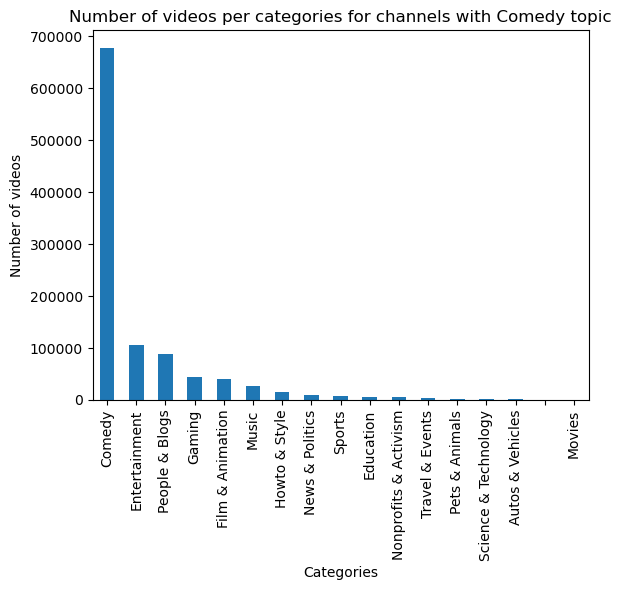

In [10]:
# select the channels as main topic "Comedy" and which are present in the channels df
comedy_ids = channels_df[channels_df.category_cc == "Comedy"].channel
# select these channels in the metadatas
metadatas_comedy = metadatas_df[metadatas_df.channel_id.isin(comedy_ids)]
metadatas_comedy.categories.value_counts().plot(kind="bar")
plt.title("Number of videos per categories for channels with Comedy topic")
plt.xlabel("Categories")
plt.ylabel("Number of videos")


Find channels with unique topic


In [11]:
comedy_channels_with_categories = metadatas_comedy.groupby("channel_id").apply(
    lambda group: group.categories.unique()
)
unique_topic_comedy = comedy_channels_with_categories.loc[
    comedy_channels_with_categories.str.len() == 1
]
non_unique_topic_comedy = comedy_channels_with_categories.loc[
    comedy_channels_with_categories.str.len() > 1
]
print("nb of channels with unique topic Comedy : ", unique_topic_comedy.shape)
print("nb of channels without unique topic Comedy : ", non_unique_topic_comedy.shape)

# exceptions in the dataset
unique_topic_comedy.value_counts()


nb of channels with unique topic Comedy :  (536,)
nb of channels without unique topic Comedy :  (3231,)


[Comedy]            523
[Entertainment]       5
[People & Blogs]      4
[Music]               2
[Gaming]              2
dtype: int64

We have exceptions in the dataset we filter. We can see in the cell above that some channels are classified as Comedy, but none of their videos are classified as Comedy. This could be a problem caused by a difference in the crawl date (the channels changed topic at some point). Let's delete these channels. Notice that we have the same excpetions for the 2 other categories. 


In [12]:
# exceptions in the dataset
category = "Comedy"

print(unique_topic_comedy.shape)
unique_topic_comedy = unique_topic_comedy[unique_topic_comedy == category]
print(unique_topic_comedy.shape)

print(non_unique_topic_comedy.shape)
condition = non_unique_topic_comedy.apply(lambda list_cond: category in list_cond)
non_unique_topic_comedy = non_unique_topic_comedy[condition]
print(non_unique_topic_comedy.shape)


(536,)
(523,)
(3231,)
(3222,)


In [13]:
blogs_channels_with_categories = metadatas_people_blogs.groupby("channel_id").apply(
    lambda group: group.categories.unique()
)
unique_topic_blog = blogs_channels_with_categories.loc[
    blogs_channels_with_categories.str.len() == 1
]
non_unique_topic_blog = blogs_channels_with_categories.loc[
    blogs_channels_with_categories.str.len() > 1
]
print("nb of channels with unique topic People & Blogs : ", unique_topic_blog.shape)
print(
    "nb of channels without unique topic People & Blogs : ", non_unique_topic_blog.shape
)
unique_topic_blog.value_counts()


nb of channels with unique topic People & Blogs :  (8723,)
nb of channels without unique topic People & Blogs :  (9690,)


[People & Blogs]          8639
[Entertainment]             20
[Gaming]                    13
[Music]                     13
[Howto & Style]             10
[Education]                  9
[Film & Animation]           9
[Sports]                     3
[Comedy]                     3
[Science & Technology]       3
[News & Politics]            1
dtype: int64

In [14]:
# exceptions in the dataset
category = "People & Blogs"

print(unique_topic_blog.shape)
unique_topic_blog = unique_topic_blog[unique_topic_blog == category]
print(unique_topic_blog.shape)

print(non_unique_topic_blog.shape)
condition = non_unique_topic_blog.apply(lambda list_cond: category in list_cond)
non_unique_topic_blog = non_unique_topic_blog[condition]
print(non_unique_topic_blog.shape)


(8723,)
(8639,)
(9690,)
(9667,)


In [15]:
gaming_channels_with_categories = metadatas_gaming.groupby("channel_id").apply(
    lambda group: group.categories.unique()
)
unique_topic_gaming = gaming_channels_with_categories.loc[
    gaming_channels_with_categories.str.len() == 1
]
non_unique_topic_gaming = gaming_channels_with_categories.loc[
    gaming_channels_with_categories.str.len() > 1
]
print("nb of channels with unique topic Gaming : ", unique_topic_gaming.shape)
print("nb of channels without unique topic Gaming : ", non_unique_topic_gaming.shape)
unique_topic_gaming.value_counts()


nb of channels with unique topic Gaming :  (5952,)
nb of channels without unique topic Gaming :  (14191,)


[Gaming]                  5913
[Entertainment]             16
[People & Blogs]             8
[Film & Animation]           4
[Music]                      4
[Howto & Style]              3
[Education]                  2
[Sports]                     1
[Science & Technology]       1
dtype: int64

In [16]:
# exceptions in the dataset
category = "Gaming"

print(unique_topic_gaming.shape)
unique_topic_gaming = unique_topic_gaming[unique_topic_gaming == category]
print(unique_topic_gaming.shape)

print(non_unique_topic_gaming.shape)
condition = non_unique_topic_gaming.apply(lambda list_cond: category in list_cond)
non_unique_topic_gaming = non_unique_topic_gaming[condition]
print(non_unique_topic_gaming.shape)


(5952,)
(5913,)
(14191,)
(14173,)


In [17]:
unique_topic_comedy_channels_descript = channels_df[
    channels_df.channel.isin(unique_topic_comedy.index.values)
]
non_unique_topic_comedy_channels_descript = channels_df[
    channels_df.channel.isin(non_unique_topic_comedy.index.values)
]


In [18]:
unique_topic_blogs_channels_descript = channels_df[
    channels_df.channel.isin(unique_topic_blog.index.values)
]
non_unique_topic_blogs_channels_descript = channels_df[
    channels_df.channel.isin(non_unique_topic_blog.index.values)
]


In [19]:
unique_topic_gaming_channels_descript = channels_df[
    channels_df.channel.isin(unique_topic_gaming.index.values)
]
non_unique_topic_gaming_channels_descript = channels_df[
    channels_df.channel.isin(non_unique_topic_gaming.index.values)
]


### Now we have the dataset to check the different between unique and non unique categories channels


In [20]:
def get_confidence_interval(data):
    rng = np.random.default_rng()
    return bootstrap(
        (data,),
        np.mean,
        confidence_level=0.95,
        random_state=rng,
    ).confidence_interval


In [24]:
conf1 = get_confidence_interval(unique_topic_comedy_channels_descript.subscribers_cc)
print(
    "95% confidence interval of number of subs for unique Comedy channels [{:_}, {:_}]".format(
        int(conf1[0]), int(conf1[1])
    )
)
conf2 = get_confidence_interval(
    non_unique_topic_comedy_channels_descript.subscribers_cc
)
print(
    "95% confidence interval of number of subs for non unique Comedy channels [{:_}, {:_}]".format(
        int(conf2[0]), int(conf2[1])
    )
)


95% confidence interval of number of subs for unique Comedy channels [320_047, 509_335]
95% confidence interval of number of subs for non unique Comedy channels [394_993, 493_451]


In [25]:
conf1 = get_confidence_interval(unique_topic_blogs_channels_descript.subscribers_cc)
print(
    "95% confidence interval of number of subs for unique Blogs channels [{:_}, {:_}]".format(
        int(conf1[0]), int(conf1[1])
    )
)
conf2 = get_confidence_interval(non_unique_topic_blogs_channels_descript.subscribers_cc)
print(
    "95% confidence interval of number of subs for non unique Blogs channels [{:_}, {:_}]".format(
        int(conf2[0]), int(conf2[1])
    )
)


95% confidence interval of number of subs for unique Blogs channels [111_171, 129_286]
95% confidence interval of number of subs for non unique Blogs channels [175_530, 204_489]


In [26]:
conf1 = get_confidence_interval(unique_topic_gaming_channels_descript.subscribers_cc)
print(
    "95% confidence interval of number of subs for unique Gaming channels [{:_}, {:_}]".format(
        int(conf1[0]), int(conf1[1])
    )
)
conf2 = get_confidence_interval(
    non_unique_topic_gaming_channels_descript.subscribers_cc
)
print(
    "95% confidence interval of number of subs for non unique Gaming channels [{:_}, {:_}]".format(
        int(conf2[0]), int(conf2[1])
    )
)


95% confidence interval of number of subs for unique Gaming channels [159_073, 185_821]
95% confidence interval of number of subs for non unique Gaming channels [199_583, 242_647]


From these statistics, we can notice that diverse channels have more subs in general. 
